In [1]:
import os, keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from utils.Dataset import CraneDataset, create_lstm_dataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [2]:
seq_len = 30
pred_distance = 30

In [3]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

In [4]:
dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()

feature_names = dataset_inst.get_data_feature_names()
target_names = dataset_inst.get_data_target_names()

for t_name in target_names:
    raw_dataset[t_name] = raw_dataset[t_name]/1000

for t_name in target_names:
    raw_dataset = raw_dataset[raw_dataset[t_name]>1]

for name in feature_names[3:6]:
    raw_dataset[name] = raw_dataset[name]*1000
    
raw_dataset = raw_dataset[raw_dataset['Time(sec)'] > 4]

raw_dataset = raw_dataset[::10]
raw_dataset.reset_index(drop=True, inplace=True)

grad_boom_angle = np.gradient(raw_dataset['Boom_Angle(deg)'])
grad_swing_angle = np.gradient(raw_dataset['Swing_Angle(deg)'])
grad_roll_angle = np.gradient(raw_dataset['Roll_Angle(deg)'])
grad_pitch_angle = np.gradient(raw_dataset['Pitch_Angle(deg)'])

extra_feature_name_list = ['grad_boom_angle', 'grad_swing_angle', 'grad_roll_angle', 'grad_pitch_angle']
feature_names = feature_names + extra_feature_name_list

for extra_feature_name, extra_feature  in zip(extra_feature_name_list, [grad_boom_angle, grad_swing_angle, grad_roll_angle, grad_pitch_angle]):
    raw_dataset[extra_feature_name] = extra_feature

train_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 0]
train_dataset = train_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
train_dataset = train_dataset[feature_names+target_names]

val_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 1]
val_dataset = val_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
val_dataset = val_dataset[feature_names+target_names]

  0%|          | 0/22 [00:00<?, ?it/s]

In [5]:
pred_distance_list_set = [10, 20, 30]

val_target_list = []
val_pred_list = []
pos_list = []
pred_distance_list = []

best_model_set = list()

for pred_distance in pred_distance_list_set:
    best_model_set = list()
    
    for i in tqdm(range(10), desc=f'Loading best model of {pred_distance/10}sec'):
        best_model_set.append(keras.models.load_model(os.path.join('models', f'lstm_model_{i}_{pred_distance}.keras')))    
        
    for i in tqdm(range(5), desc=f'calculate prediction of {pred_distance/10}sec'):
        j = i+5
        val_left_feature, val_left_target = create_lstm_dataset(val_dataset.to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=10+i)
        
        val_left_pred = np.squeeze(best_model_set[i].predict(val_left_feature, verbose=0))
        
        val_target_list.append(val_left_target)
        val_pred_list.append(val_left_pred)
        pos_list.append(np.full(shape=(val_left_pred.shape[0]), fill_value=0))
        
        val_right_feature, val_right_target = create_lstm_dataset(val_dataset.to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=10+j)
    
        val_right_pred = np.squeeze(best_model_set[j].predict(val_right_feature, verbose=0))
    
        val_target_list.append(val_right_target)
        val_pred_list.append(val_right_pred)
        pos_list.append(np.full(shape=(val_right_pred.shape[0]), fill_value=1))
    
        pred_distance_list.append(np.full(shape=(val_left_target.shape[0]+val_right_target.shape[0]), fill_value=pred_distance))   

Loading best model of 1.0sec:   0%|          | 0/10 [00:00<?, ?it/s]

calculate prediction of 1.0sec:   0%|          | 0/5 [00:00<?, ?it/s]

Loading best model of 2.0sec:   0%|          | 0/10 [00:00<?, ?it/s]

calculate prediction of 2.0sec:   0%|          | 0/5 [00:00<?, ?it/s]

Loading best model of 3.0sec:   0%|          | 0/10 [00:00<?, ?it/s]

calculate prediction of 3.0sec:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
rela_error = (np.abs(np.concatenate(val_target_list)-np.concatenate(val_pred_list))/np.concatenate(val_target_list))*100
rela_error = rela_error.reshape(-1, 1)

result = np.hstack([np.concatenate(val_target_list).reshape(-1, 1), np.concatenate(val_pred_list).reshape(-1, 1), rela_error, 
                    np.concatenate(pos_list).reshape(-1, 1), np.concatenate(pred_distance_list).reshape(-1, 1)])
result_pd = pd.DataFrame(result, columns=['target', 'pred', 'error', 'pos', 'pred_distance'])

In [7]:
for pred_distance in pred_distance_list_set:
    for pos in [0, 1]:
        target = result_pd[result_pd['pos']==pos]
        target = target[target['pred_distance']==pred_distance]['target']
        
        pred = result_pd[result_pd['pos']==pos]
        pred = pred[pred['pred_distance']==pred_distance]['pred']
        
        print(r2_score(target, pred), mean_absolute_error(target, pred), mean_absolute_percentage_error(target, pred))

0.9234668496154033 14.537568393715814 0.05968878493117324
0.9181599837406946 13.130638355631095 0.21627650227475956
0.8530412136576706 18.734199179507925 0.07722586136688463
0.8553398014279788 18.96957317830162 0.2794184403643771
0.8474857911288854 19.984186816967085 0.0860821076558462
0.79905038618912 21.847866963816568 0.3185087634899578


In [8]:
for pred_distance in pred_distance_list_set:
    target = result_pd[result_pd['pred_distance']==pred_distance]['target']
    pred = result_pd[result_pd['pred_distance']==pred_distance]['pred']
    
    print(r2_score(target, pred), mean_absolute_error(target, pred), mean_absolute_percentage_error(target, pred))

0.940753486646239 13.834103374673454 0.13798264360296636
0.891512285927839 18.85188617890477 0.17832215086563086
0.8699736477403214 20.916026890391823 0.202295435572902


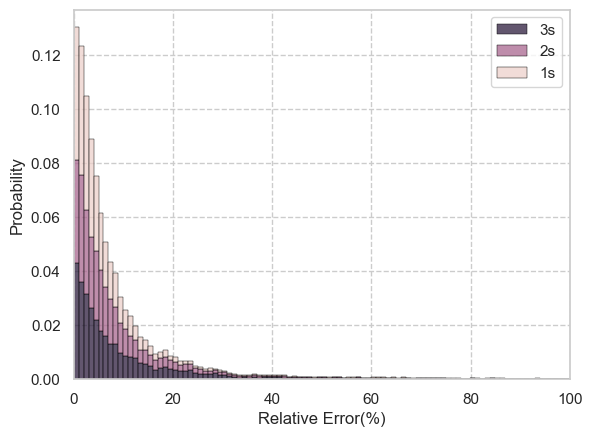

In [9]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(data=result_pd[result_pd['error'] <= 100], x='error', hue='pred_distance', stat='probability', bins=100, multiple='stack', edgecolor='black')

plt.xlim(0, 100)
plt.xlabel('Relative Error(%)')
plt.ylabel('Probability')
plt.legend(['3s', '2s', '1s'])

Text(0, 0.5, 'Relative Error(%)')

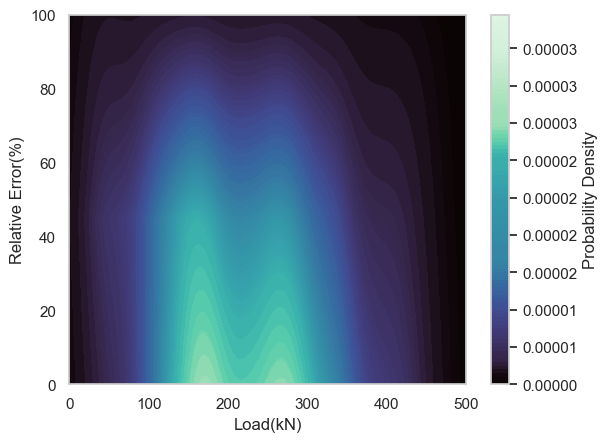

In [10]:
sns.set_theme(font_scale=1.0, style='dark')
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.kdeplot(data=result_pd[result_pd['pred_distance']==10], x='target', y='error', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.5f'})

plt.xlim((0, 500))
plt.xlabel('Load(kN)')

plt.ylim(0, 100)
plt.ylabel('Relative Error(%)')

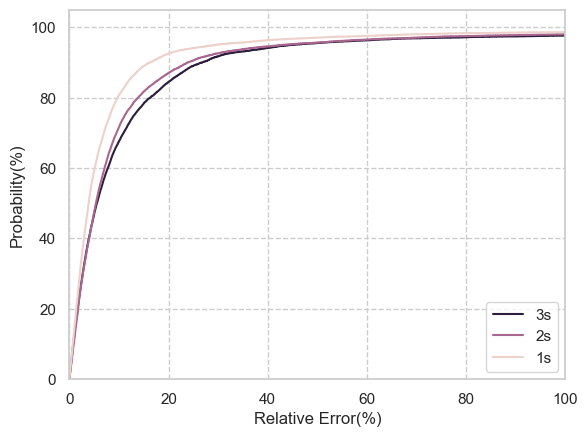

In [13]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.ecdfplot(data=result_pd, x='error', hue='pred_distance', stat='percent')

plt.xlim(0, 100)
plt.xlabel('Relative Error(%)')

plt.ylabel('Probability(%)')
plt.legend(['3s', '2s', '1s'])

In [50]:
error = result_pd[result_pd['pred_distance']==30]['error']

hist, bin_edge = np.histogram(error, bins=100000)
cum_error = np.cumsum(hist)
cum_error = cum_error / np.max(cum_error)

cum_error[np.argmin(np.abs(bin_edge-10))]

0.6771570014144271

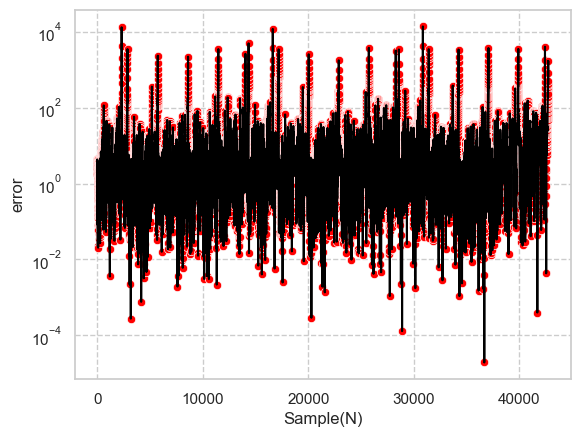

In [254]:
result_pd_1 = result_pd[::300]

sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.lineplot(data=result_pd, x=np.arange(result_pd.shape[0]), y='error', color='black')
sns.scatterplot(data=result_pd, x=np.arange(result_pd.shape[0]), y='error', color='red')

#plt.xlim(0, 10000)
plt.xlabel('Sample(N)')
plt.yscale('log')

In [10]:
val_target_list = []
val_pred_list = []

for i in tqdm(range(10), desc='calculate predictions'):
    val_feature, val_target = create_lstm_dataset(val_dataset.to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=10+i)
    
    val_pred = np.squeeze(best_model_set[i].predict(val_feature, verbose=2))
    
    val_target_list.append(val_target)
    val_pred_list.append(val_pred)

calculate predictions:   0%|          | 0/10 [00:00<?, ?it/s]

220/220 - 1s - 937ms/epoch - 4ms/step
45/45 - 0s - 232ms/epoch - 5ms/step
220/220 - 1s - 968ms/epoch - 4ms/step
45/45 - 0s - 231ms/epoch - 5ms/step
220/220 - 1s - 1s/epoch - 5ms/step
45/45 - 0s - 216ms/epoch - 5ms/step
220/220 - 1s - 1s/epoch - 5ms/step
45/45 - 0s - 256ms/epoch - 6ms/step
220/220 - 1s - 1s/epoch - 5ms/step
45/45 - 0s - 210ms/epoch - 5ms/step
220/220 - 1s - 976ms/epoch - 4ms/step
45/45 - 0s - 230ms/epoch - 5ms/step
220/220 - 1s - 1s/epoch - 5ms/step
45/45 - 0s - 223ms/epoch - 5ms/step
220/220 - 1s - 1s/epoch - 5ms/step
45/45 - 0s - 204ms/epoch - 5ms/step
220/220 - 1s - 954ms/epoch - 4ms/step
45/45 - 0s - 210ms/epoch - 5ms/step
220/220 - 1s - 956ms/epoch - 4ms/step
45/45 - 0s - 247ms/epoch - 5ms/step


In [11]:
print(r2_score(np.stack(val_target_list, axis=1), np.stack(val_pred_list, axis=1)),
      mean_absolute_error(np.stack(val_target_list, axis=1), np.stack(val_pred_list, axis=1)),
      mean_absolute_percentage_error(np.stack(val_target_list, axis=1), np.stack(val_pred_list, axis=1)))

0.743006460040239 20.9160268601764 0.20229543516724408


In [63]:
model_history_list = []

for i in range(5):
    file_path = os.path.join('logs', f'log_{i}_{pred_distance}.csv')
    model_history_list.append(pd.read_csv(file_path))

Text(0, 0.5, 'Relative Error(%)')

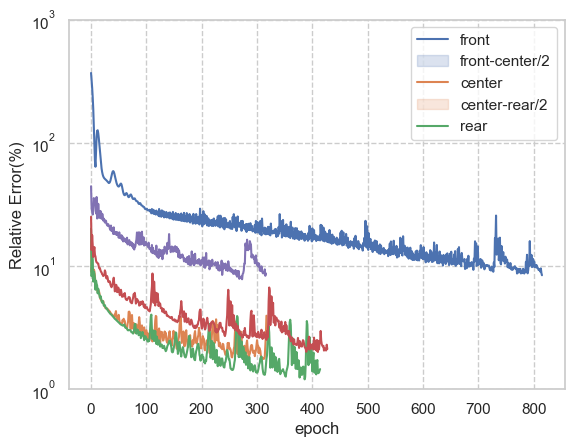

In [64]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for model_history in model_history_list:
    sns.lineplot(data=model_history, x='epoch', y='mean_absolute_percentage_error')

legend_name_list = ['front', 'front-center/2', 'center', 'center-rear/2', 'rear']
plt.legend(legend_name_list)

plt.yscale('log')
plt.ylim(1, 1000)
plt.ylabel('Relative Error(%)')

In [65]:
model_history_list = []

for i in range(5):
    i += 5
    file_path = os.path.join('logs', f'log_{i}_{pred_distance}.csv')
    model_history_list.append(pd.read_csv(file_path))

Text(0, 0.5, 'Relative Error(%)')

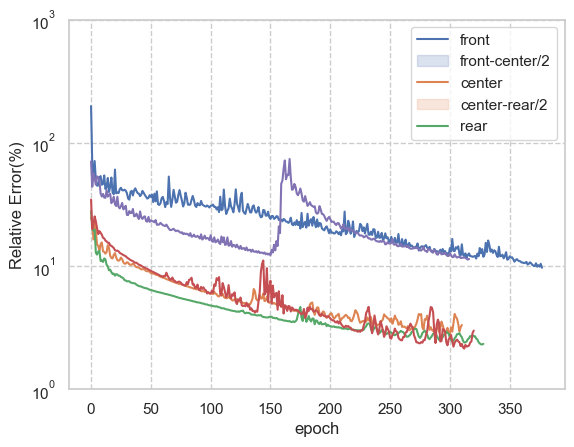

In [66]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for model_history in model_history_list:
    sns.lineplot(data=model_history, x='epoch', y='mean_absolute_percentage_error')

legend_name_list = ['front', 'front-center/2', 'center', 'center-rear/2', 'rear']
plt.legend(legend_name_list)

plt.yscale('log')
plt.ylim(1, 1000)
plt.ylabel('Relative Error(%)')